# Feature Attribution Plots Documentation

The `scikit-explain` package includes scatter plots that were originally developed in the [SHAP package](https://github.com/slundberg/shap). These plots include a scatter plot similar to demostrate feature effects (e.g. like partial dependence) and plots to demostrate feature rankings (e.g., like permutation importance). 

In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.getcwd()))

In [2]:
import skexplain
from skexplain.common.importance_utils import to_skexplain_importance
import plotting_config
import numpy as np 
import shap

### Loading the training data and pre-fit models 


In [3]:
estimators = skexplain.load_models()
X,y = skexplain.load_data()

In [4]:
# X_subset is the set of examples we want to get attribution values for.
random_state = np.random.RandomState(42)
N=100
ind = random_state.choice(len(X), size=N, replace=False)
X_subset = X.iloc[ind]
y_subset = y[ind]
X_subset.reset_index(inplace=True, drop=True)

explainer = skexplain.ExplainToolkit(estimators[0], X=X_subset,)

## Compute the Feature Attributions 

When computing SHAP values, the user has a couple options (passed in as ``shap_kwargs``). First, we need to declare the ``masker``. In this example, we are using a built-in method from the [SHAP python package](https://shap.readthedocs.io/en/latest/generated/shap.maskers.Partition.html#shap.maskers.Partition). We could also pass in a background dataset rather a masker (e.g., masker = shap.sample(X, 100).reset_index(drop=True)). Second, we can declare the SHAP algorithm we want to use. By default, we set ``algorithm = "auto"`` and the SHAP package will determine the best algorithm. If we use the Partition masker, I've found that it will default to the ``Exact`` and otherwise it will try to use ``Permutation`` (note there are other options, but for different model types).

In [5]:
# For the LIME, we must provide the training dataset. We also denote any categorical features. 
lime_kws = {'training_data' : X.values, 'categorical_names' : ['rural', 'urban']}

# As stated above, the masker handles the missing features. In this case, we are using correlations 
# in the dataset to determine the feature groupings. These groups of features are remove or added into 
# sets together. 
shap_kws={'masker' : shap.maskers.Partition(X, max_samples=100, clustering="correlation"), 
           'algorithm' : 'permutation'}

In [6]:
#contrib_ds = explainer.local_attributions(method=['shap', 'lime', 'tree_interpreter'], 
#                                           shap_kws=shap_kws,
#                                           lime_kws=lime_kws, 
#                                          )
#explainer.save('../tutorial_data/attr_values.nc', contrib_ds)

In [7]:
results = explainer.load('../tutorial_data/attr_values.nc')

## Summary Plot

Once we compute the feature attributions values for a large number of examples, we can evaluate different patterns. For example, in the plot below, feature attributions values are ranked by their absolute sum. Additionally, the feature attributions values are color-coded by their normalized magnitude where red indicates a higher predictor value while blue indicates a lower predictor value. In this case, surface temperature ($T_{sfc}$) had the largest absolute sum and lower values increases the probability of freezing road surface temperatures. 

In [ ]:
explainer.scatter_plot(
                    plot_type = 'summary',
                    dataset=results,
                    method = 'tree_interpreter',
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
        )                           

Instead of this plot, we can evaluate the SHAP-based ranking with the bar-style plot used in skexplain. 

(<Figure size 1800x750 with 5 Axes>,
 array([<AxesSubplot:xlabel='SHAP'>, <AxesSubplot:xlabel='LIME'>,
        <AxesSubplot:xlabel='TI'>], dtype=object))

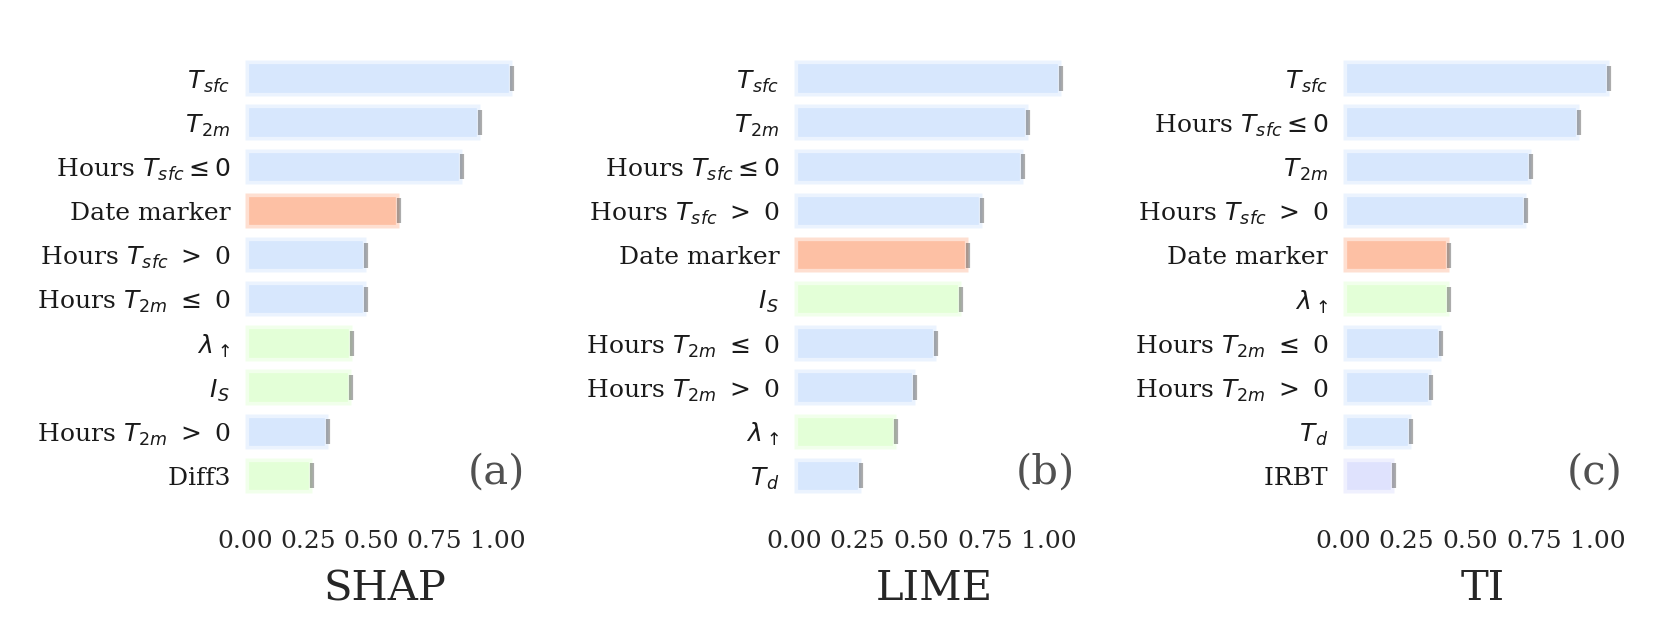

In [9]:
# Convert the shap values to importance scores for plotting.
# For SHAP values, we can use the 'shap_sum' or 'shap_std' methods available
# in to_skexplain_importance. 
shap_rank = to_skexplain_importance(results['shap_values__Random Forest'].values, 
                                    estimator_name='Random Forest', 
                               feature_names=X.columns, method='shap_sum')

lime_rank = to_skexplain_importance(results['lime_values__Random Forest'].values, 
                                    estimator_name='Random Forest', 
                               feature_names=X.columns, method='lime')

ti_rank = to_skexplain_importance(results['tree_interpreter_values__Random Forest'].values, 
                                  estimator_name='Random Forest', 
                               feature_names=X.columns, method='tree_interpreter')

explainer.plot_importance(data=[shap_rank, lime_rank, ti_rank],
                          panels = [('shap_sum', 'Random Forest'), ('lime', 'Random Forest'), 
                                   ('tree_interpreter', 'Random Forest')],
                          display_feature_names=plotting_config.display_feature_names,
                          feature_colors=plotting_config.color_dict,
                          xlabels = ['SHAP', 'LIME', 'TI']
                          )

### Dependence Plot

Feature attributions can also be displayed similar to ALE/PD curve where the values are presented as a function of the predictor value. For this plots, we can also include `histdata`, which is a combination of `X` and `y`. For classification problems, the user can provide the name of the target variable and the background histogram will be color-coded for the different classes. Lastly, each dot is color coded by the value of the feature that approximately interacts with the feature being plotted. 


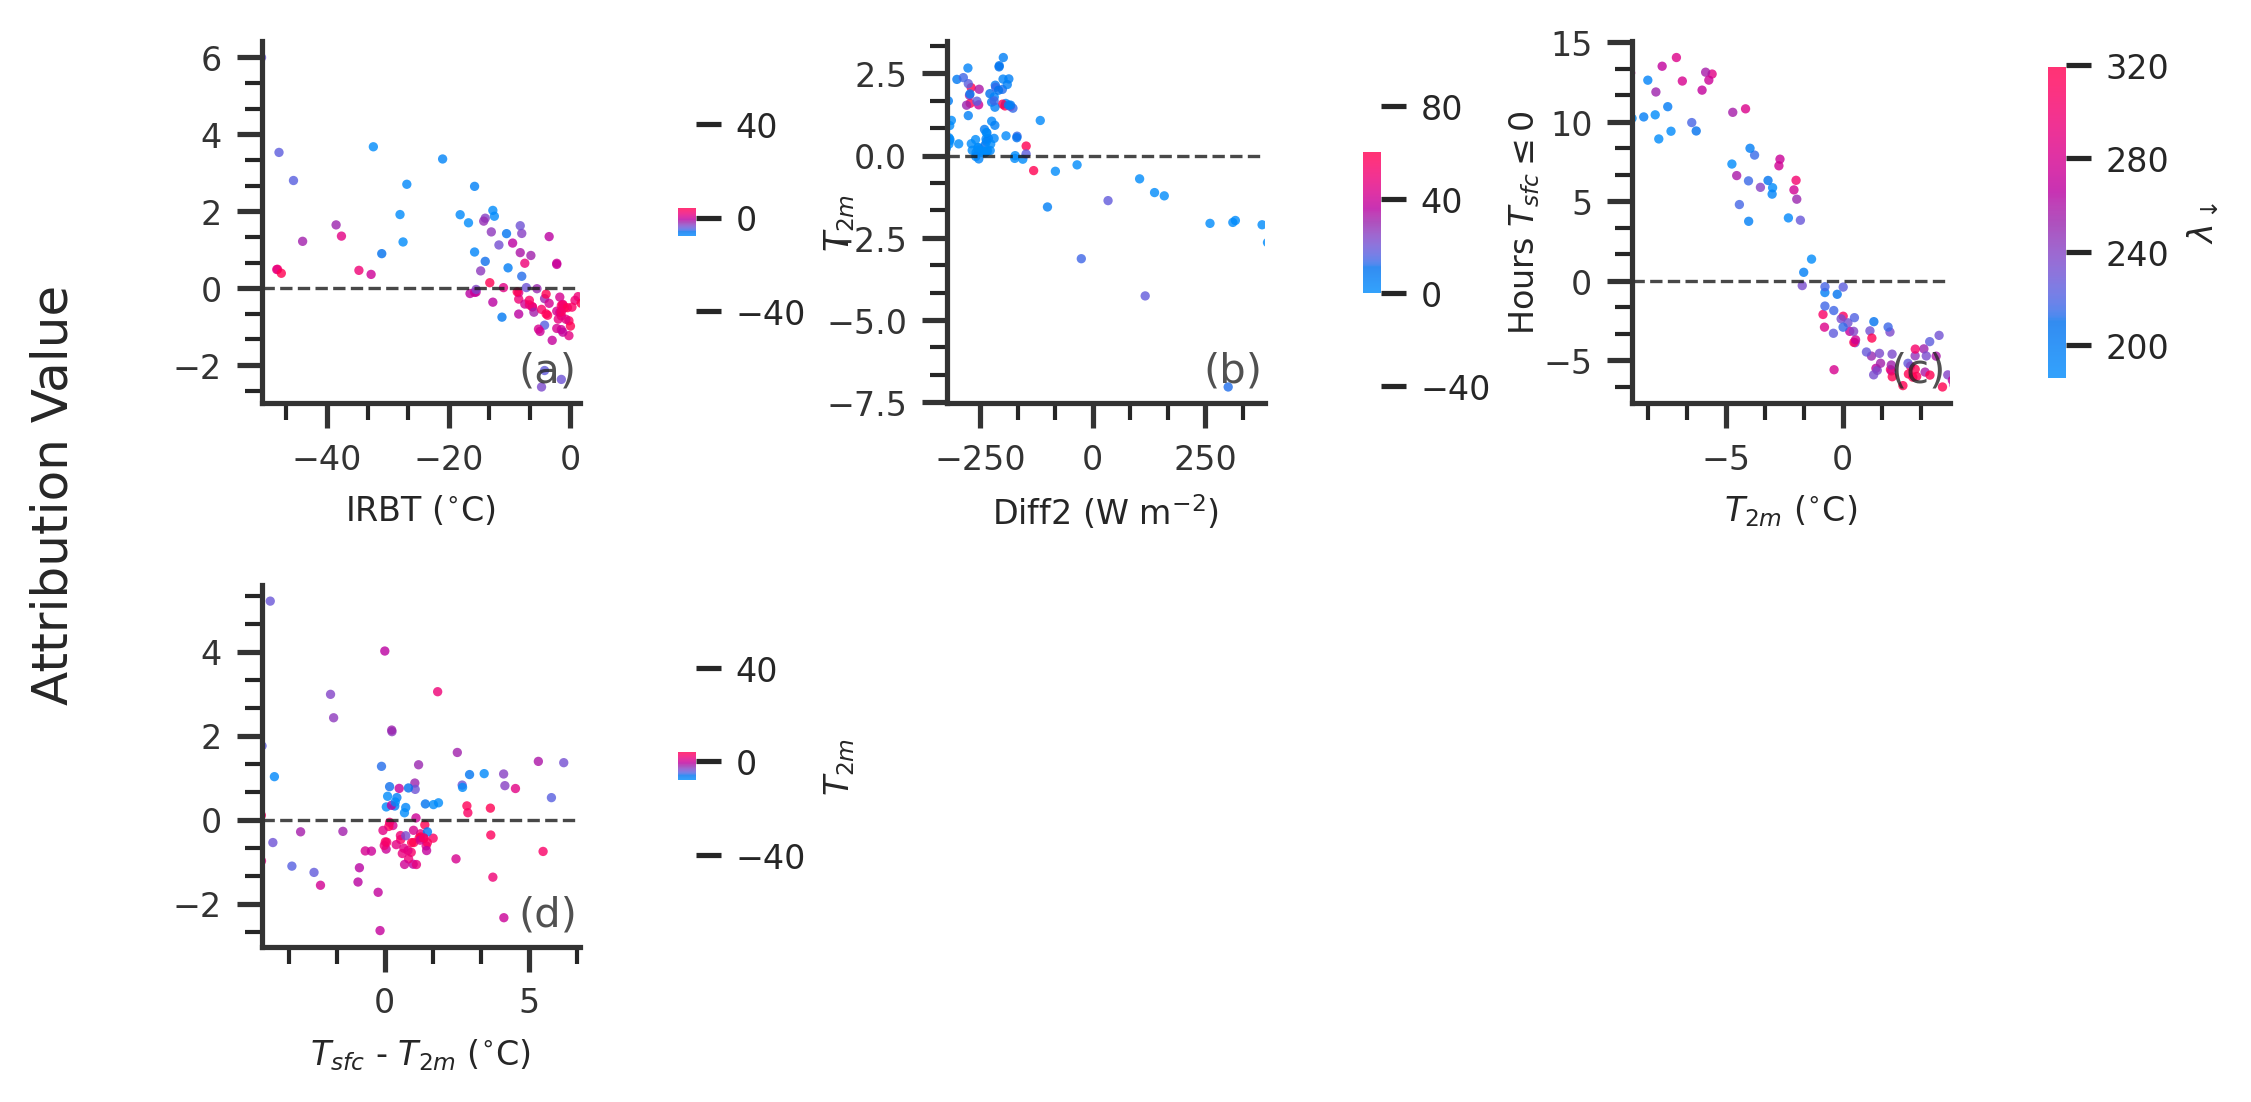

In [8]:
features = ['sat_irbt','d_rad_d', 'temp2m', 'hrrr_dT']
methods = ['shap']

histdata=X_subset.copy()
histdata['target'] = y_subset

explainer.scatter_plot(features=features,
                    plot_type = 'dependence',
                    dataset=results,
                    method = methods, 
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    interaction_index='auto', 
                    figsize=(8,4), colorbar_pad=0.2
)

histdata=       dllwave_flux  dwpt2m  fric_vel  gflux  high_cloud  lat_hf  low_cloud  \
0             211.0  -2.504      0.28   44.0       0.000   -10.0      8.875   
1             241.2  -4.168      0.36  -10.0       0.000    70.0     13.125   
2             242.0  -2.172      0.31   43.0       0.000    25.0      0.000   
3             220.4  -3.291      0.62   75.0       0.000    30.0      0.000   
4             212.9  -5.020      0.15   50.0       0.000     0.0      0.000   
...             ...     ...       ...    ...         ...     ...        ...   
99995         264.2  -5.895      0.02   39.0      15.625     0.0      0.000   
99996         191.6 -10.664      0.39   29.0       0.000     0.0      4.125   
99997         296.8   1.303      0.36   33.0       0.000    13.0     33.120   
99998         257.0   0.782      0.11   40.0       0.250     5.0     10.000   
99999         325.5   1.399      0.28   11.0       0.000    20.0     70.500   

       mid_cloud  sat_irbt  sens_hf  ...  

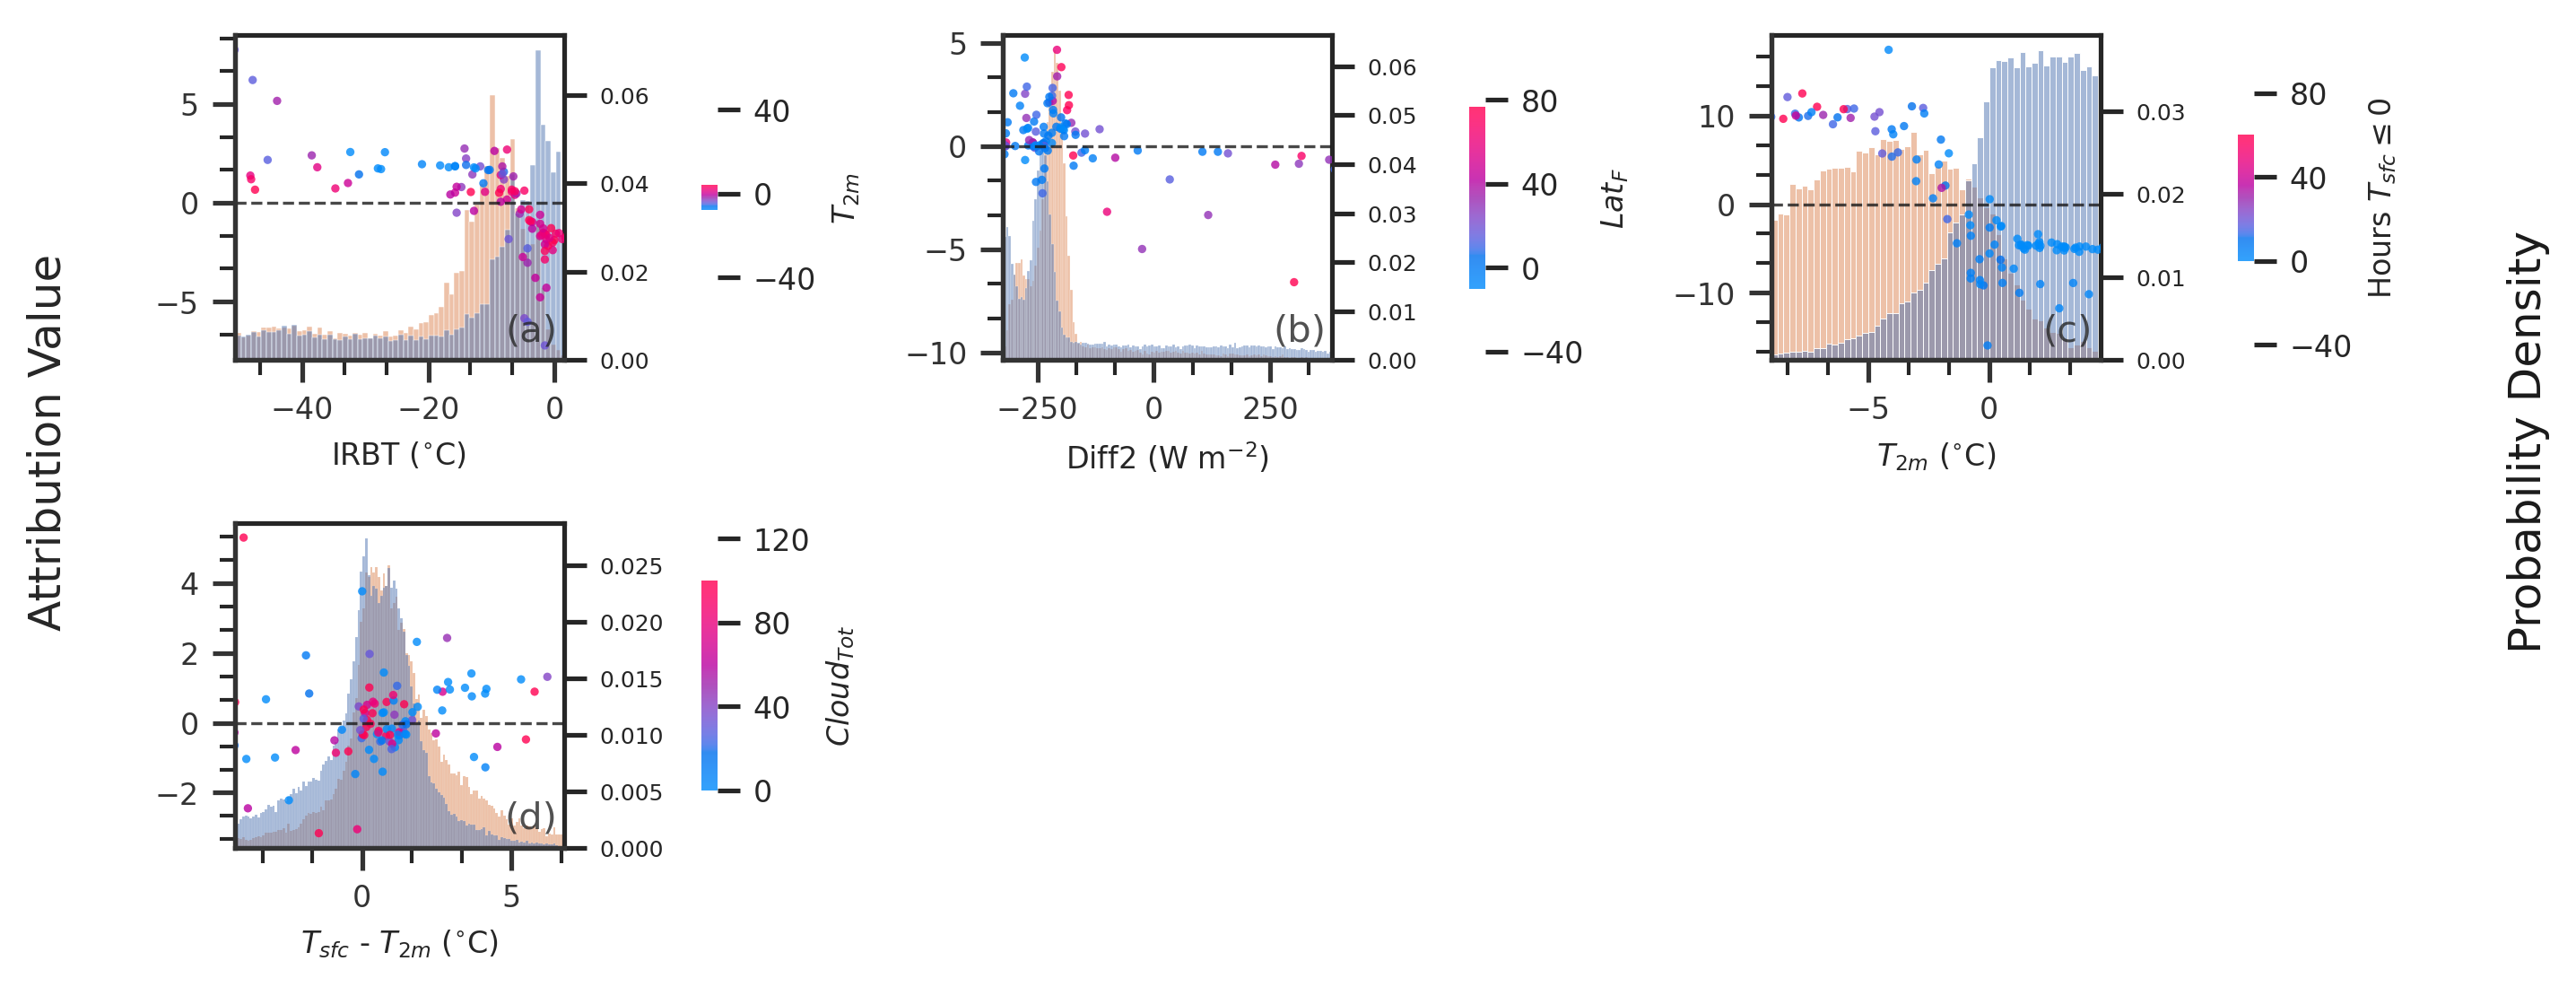

In [9]:
features = ['sat_irbt', 'd_rad_d', 'temp2m', 'hrrr_dT']
methods = ['tree_interpreter']

histdata=X.copy()
histdata['target'] = y

explainer.scatter_plot(features=features,
                    plot_type = 'dependence',
                    dataset=results,
                    method = methods, 
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    histdata=histdata,
                    target='target',
                    interaction_index='auto', 
                    figsize=(10,4), colorbar_pad=0.25
)

## No color-coding of dots 

Set `interaction_index=None` to remove the color-coding. 

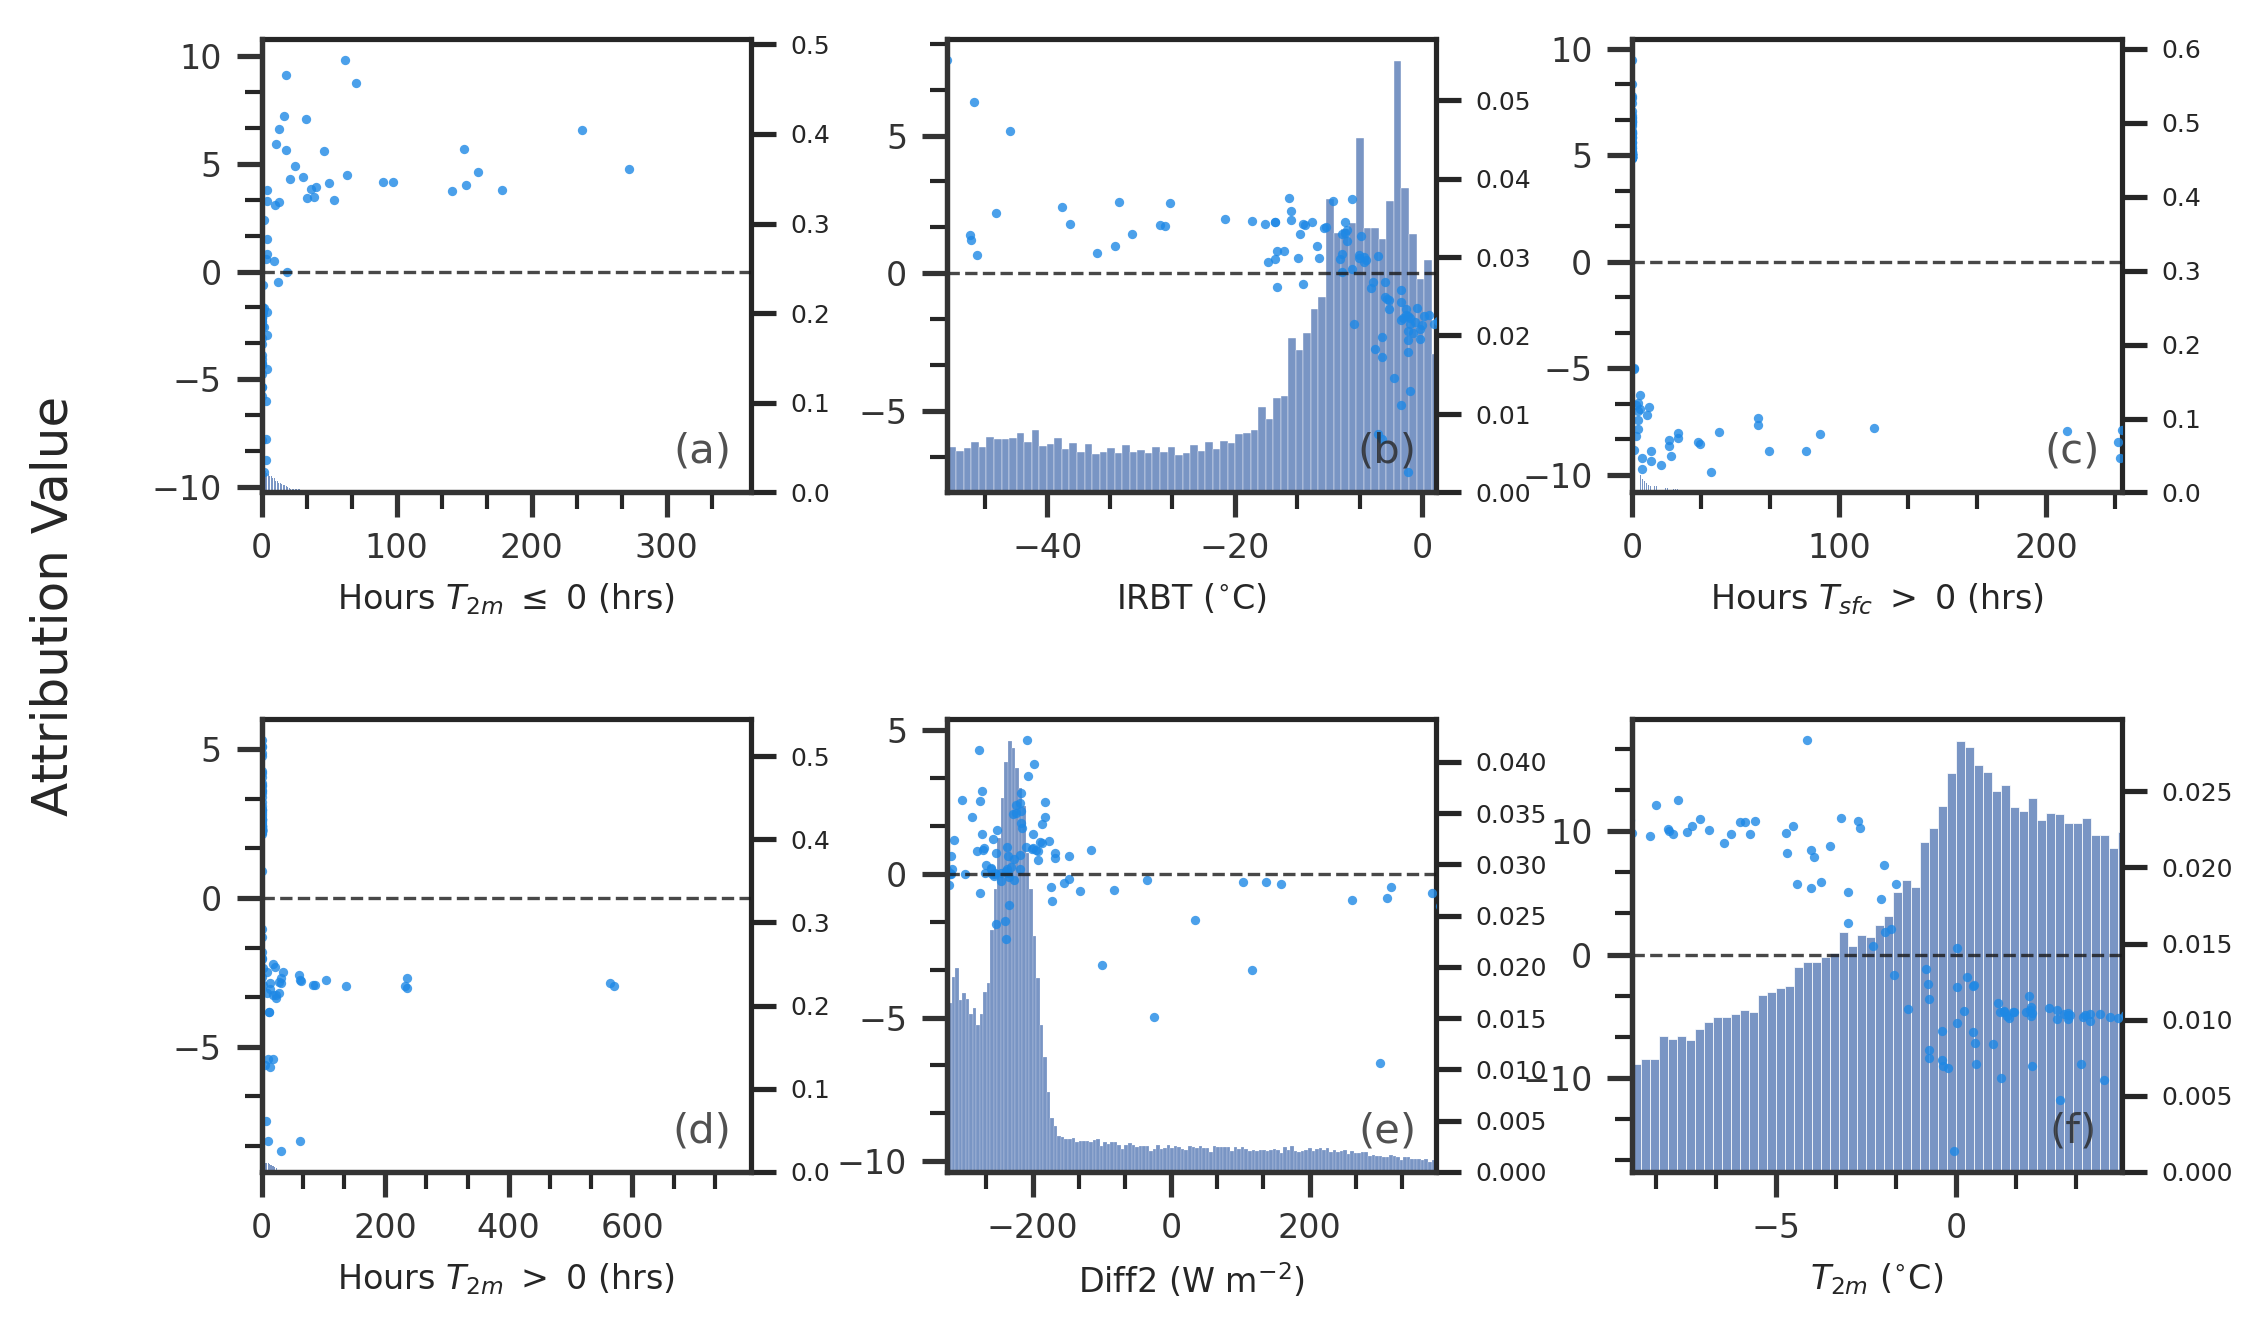

In [14]:
features = ['tmp2m_hrs_bl_frez', 'sat_irbt', 'sfcT_hrs_ab_frez', 'tmp2m_hrs_ab_frez', 'd_rad_d', 'temp2m']

explainer.scatter_plot(features=features,
                    plot_type = 'dependence',
                    dataset=results,
                    method = ['tree_interpreter'],
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    histdata=histdata,
                    interaction_index=None,
)

## Color-code the dots by the target value.

To color by the target values, set the target_values to y and keep `interaction_index=None`


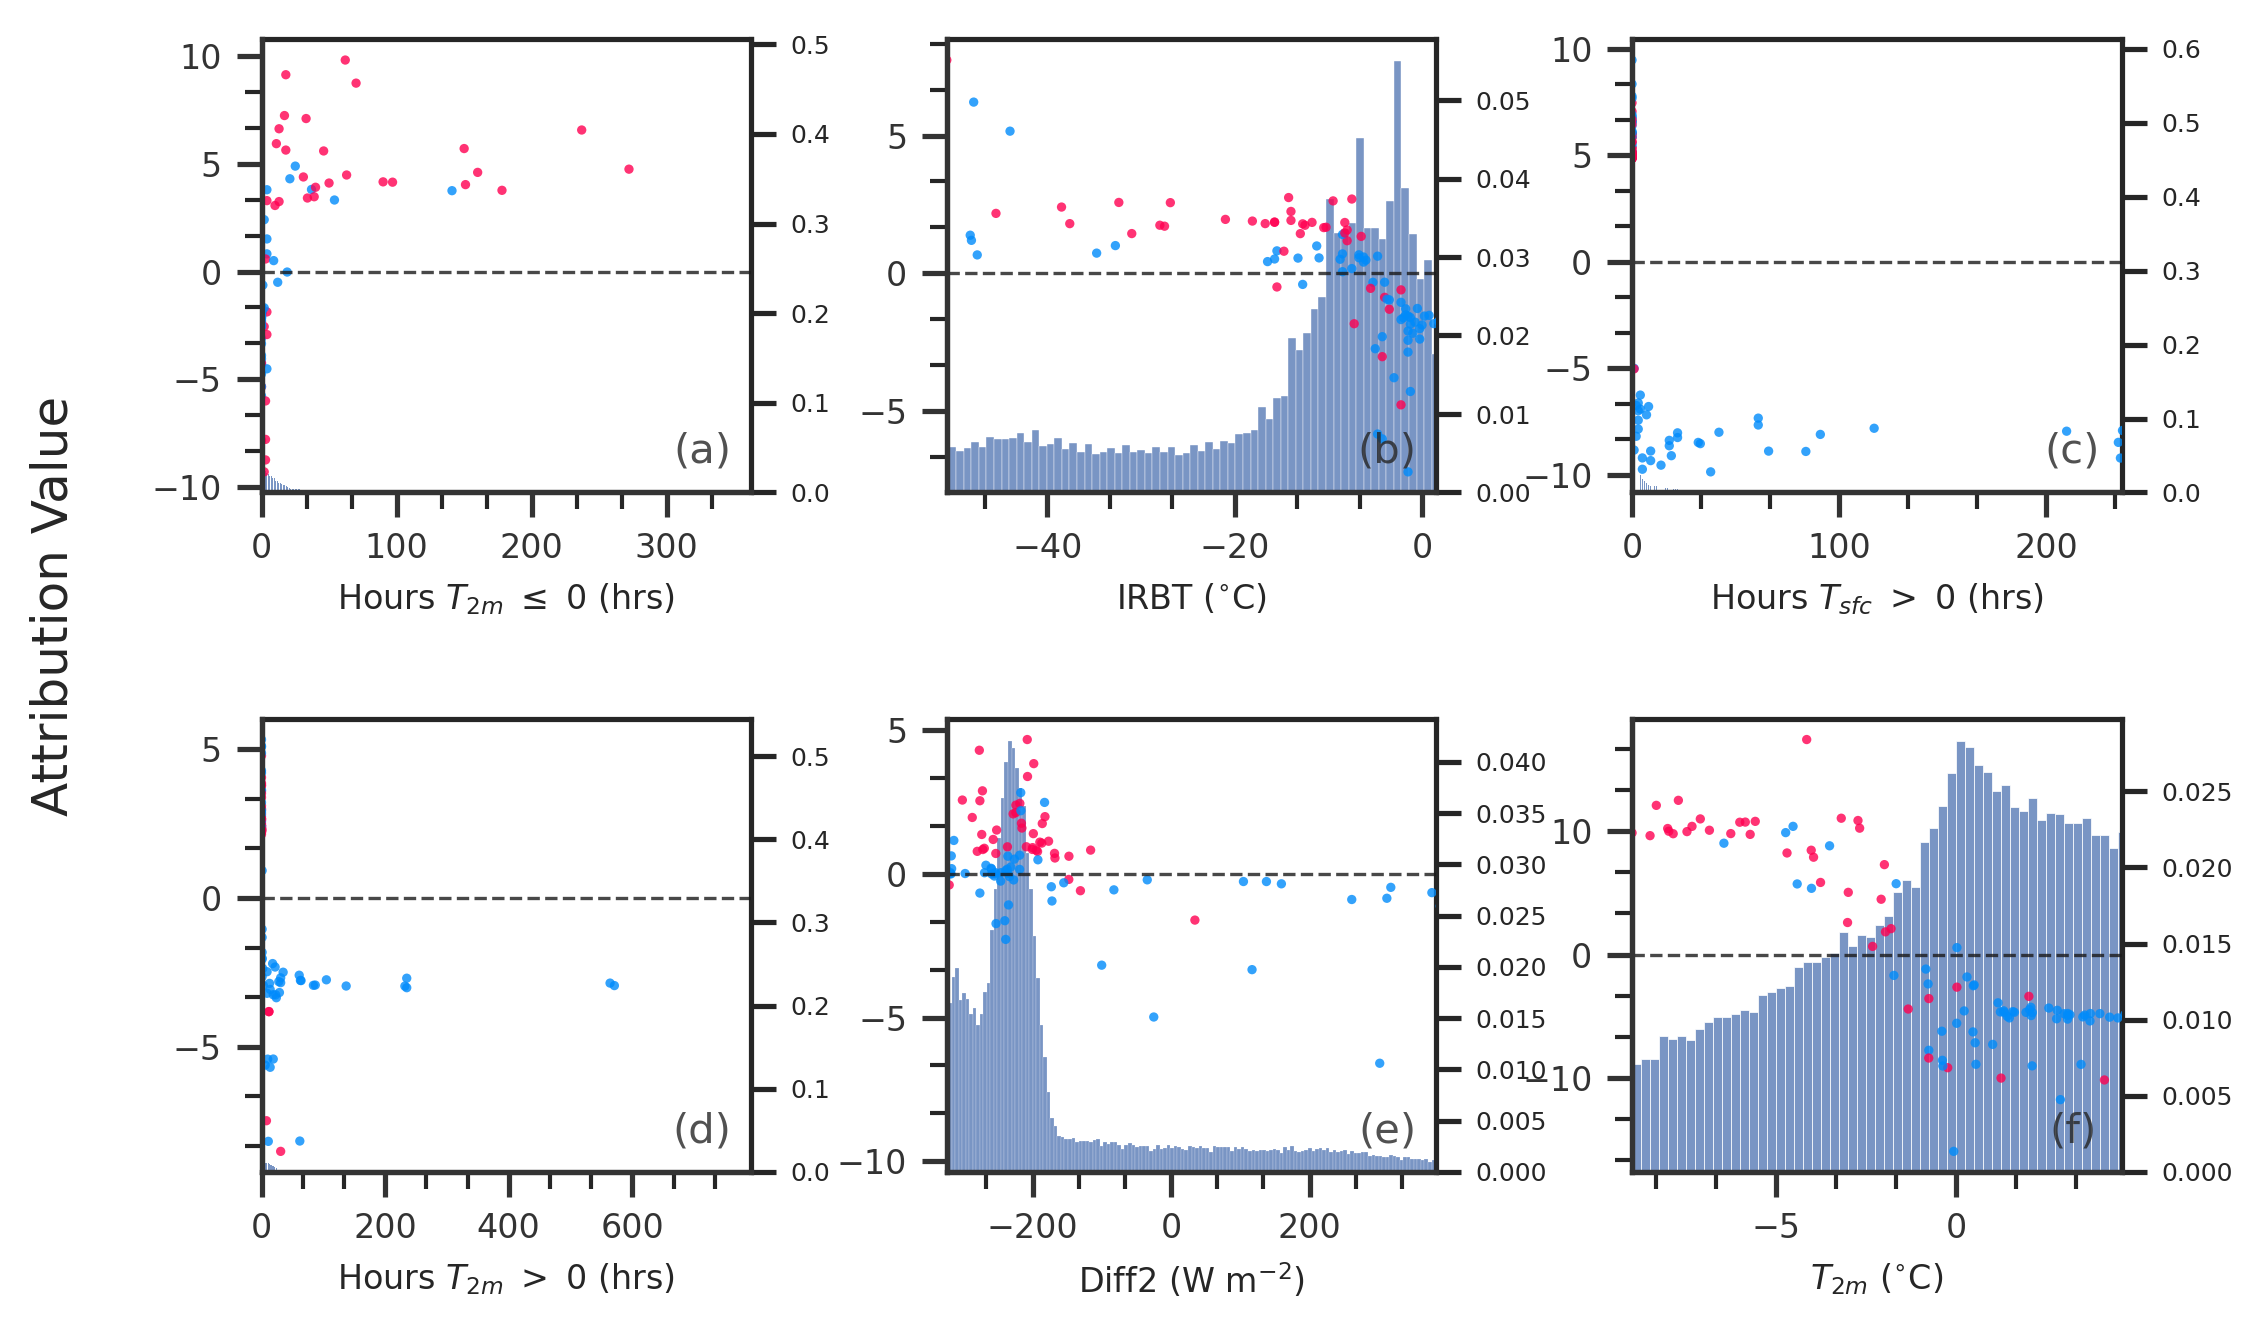

In [15]:
features = ['tmp2m_hrs_bl_frez', 'sat_irbt', 'sfcT_hrs_ab_frez', 'tmp2m_hrs_ab_frez', 'd_rad_d', 'temp2m']

explainer.scatter_plot(features=features,
                    plot_type = 'dependence',
                    dataset=results,
                    method = ['tree_interpreter'],
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    histdata=histdata,
                    target_values=y_subset, 
                    interaction_index=None,
)

## SHAP for Regression

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
model= RandomForestRegressor()
model.fit(X,y)

In [ ]:
# X_subset is the set of examples we want to get SHAP values for.
random_state = np.random.RandomState(42)

ind = random_state.choice(len(X), size=100, replace=False)
X_subset = X[ind]
y_subset = y[ind]

In [ ]:
explainer = skexplain.ExplainToolkit(('Random Forest', model), X=X_subset, feature_names=feature_names)

In [ ]:
results = explainer.local_attributions('shap', shap_kws={
    'masker' : shap.maskers.Partition(X, max_samples=100, clustering='correlation'),
    'algorithm' : 'permutation'})

In [ ]:
explainer.scatter_plot(
                    plot_type = 'summary',
                    estimator_name = 'Random Forest',
                    values=results['shap_values__Random Forest'].values,
                    display_feature_names=plotting_config.display_feature_names,
)                           

In [ ]:
explainer.scatter_plot(
                    plot_type = 'dependence',
                    estimator_name = 'Random Forest',
                    dataset=results,
                    features = feature_names, 
                    display_feature_names=plotting_config.display_feature_names,
)                         